In [1]:
from pathlib import Path
import sys


import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
import logging
import tifffile
from colokroll.core.format_converter import FormatConverter
from colokroll.data_processing import ImageLoader
from colokroll.imaging_preprocessing.background_subtraction.background_subtractor import BackgroundSubtractor
from colokroll.analysis.cell_segmentation import CellSegmenter
from colokroll.analysis.colocalization import compute_colocalization, export_colocalization_json


# Setup logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

/users/PAS2598/duarte63/GitHub/perinuclear_analysis/colokroll/__init__.py:41: UserWarning: MIPPreprocessor not available yet
  warnings.warn("MIPPreprocessor not available yet")
/users/PAS2598/duarte63/GitHub/perinuclear_analysis/colokroll/__init__.py:61: UserWarning: Phase 4 dependencies not installed: No module named 'colokroll.ring_analysis'
Install with: pip install .[phase4]
  warnings.warn(
/users/PAS2598/duarte63/GitHub/perinuclear_analysis/colokroll/__init__.py:74: UserWarning: Phase 5 dependencies not installed: No module named 'colokroll.signal_quantification'
Install with: pip install .[phase5]
  warnings.warn(


In [2]:
image_path = Path("/fs/scratch/PAS2598/duarte63/ALIX_confocal_data/ALIX/nd2/anti_ALIX_120_min_4.nd2")
image_loader = ImageLoader()

loaded_data = image_loader.load_image(image_path)
image_loader.get_pixel_size()
loaded_data.dtype

INFO: Converting anti_ALIX_120_min_4.nd2 to OME-TIFF format for pipeline compatibility
INFO: Using existing converted file: /fs/scratch/PAS2598/duarte63/ALIX_confocal_data/ALIX/nd2/anti_ALIX_120_min_4.ome.tiff
INFO: Loaded metadata from converted TIFF: pixel_size=0.108333333333333μm
INFO: Squeezed singleton dim(s): (23, 1800, 1800, 4, 1) -> (23, 1800, 1800, 4)
INFO: Successfully loaded TIFF image with shape: (23, 1800, 1800, 4)


dtype('uint16')

In [3]:
# Rename channels
new_channel_names = ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']
image_loader.rename_channels(new_channel_names)

# Check channels
channels = image_loader.get_channel_names()
print(f"Channels: {channels}")

INFO: Renamed channels to: ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


Channels: ['LAMP1', 'Phalloidin', 'ALIX', 'DAPI']


In [8]:
bg_subtractor = BackgroundSubtractor()

results = {}

for i, ch in enumerate(channels):
    ch_data = loaded_data[:, :, :, i]
    t0 = time.perf_counter()
    corrected, meta = bg_subtractor.subtract_background(
        image=ch_data,
        channel_name=ch,
        # method omitted -> auto search + full run
    )
    cp.cuda.Stream.null.synchronize()
    dt = time.perf_counter() - t0

    results[ch] = (corrected, meta)

INFO: Initializing CUDA-accelerated background subtractor (CUDA required)
INFO: GPU Memory: 39.0GB free / 39.4GB total
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=50)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=55)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=60)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=65)
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=70)
INFO: Processing 23 z-slices with CUDA rolling ball approximation (radius=50)
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=10
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=12
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=14
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=16
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=16
INFO: Processing 5 z-slices with CUDA rolling ball approximation (radius=

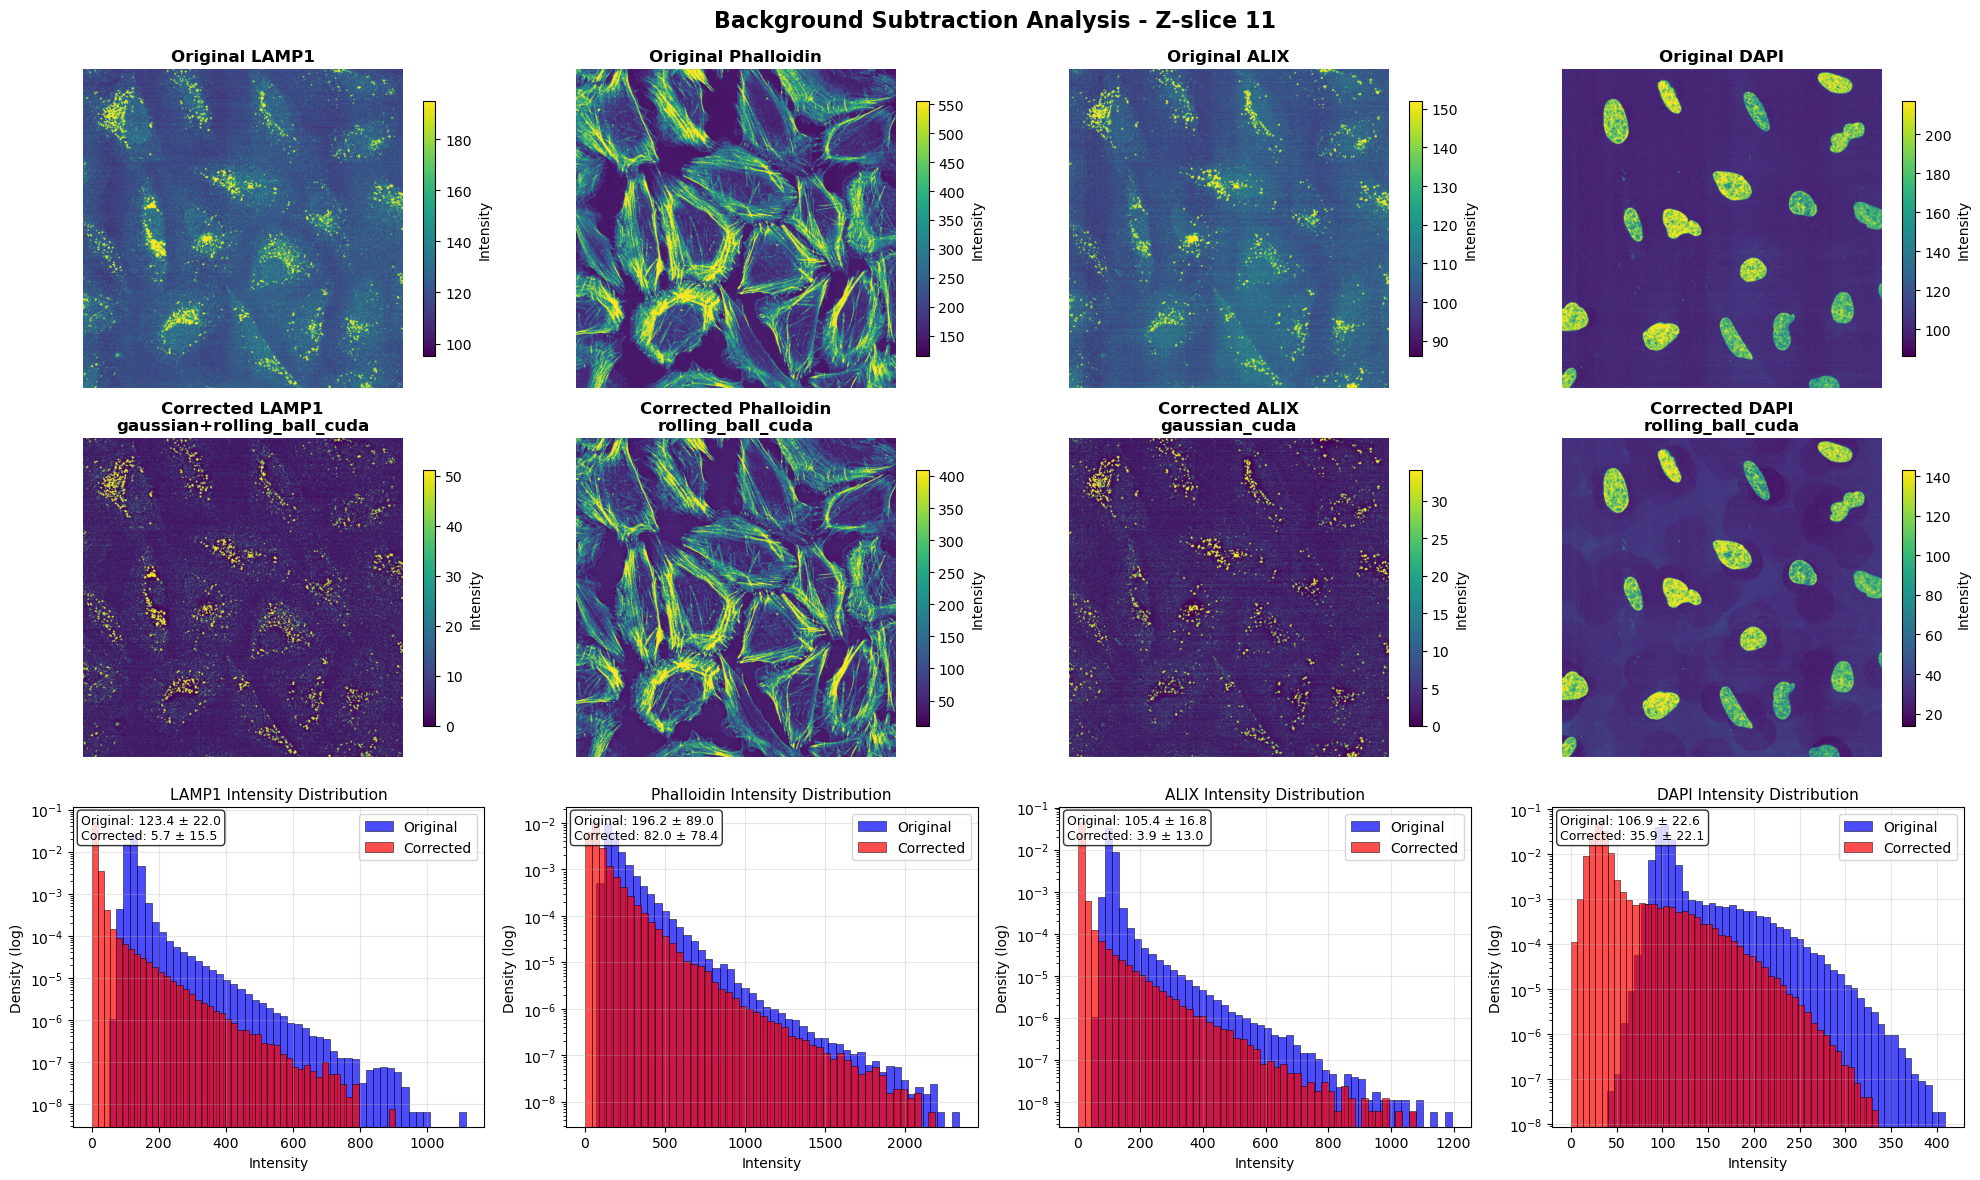

In [9]:
middle_slice_idx = loaded_data.shape[0]//2


fig = bg_subtractor.plot_background_subtraction_comparison(
    original_data=loaded_data,
    corrected_results=results,
    channel_names=channels,
    z_slice=middle_slice_idx,
    figsize=(5*len(channels), 12)
)
plt.show()

In [12]:
from gradio_client import Client, handle_file
from colokroll.analysis.segmentation_config import get_hf_token
import imageio.v3 as iio


# 0) Build/validate composite (if not already done)
def norm01(a):
    a = a.astype(np.float32); mn, mx = a.min(), a.max()
    return np.zeros_like(a) if mx <= mn else (a - mn) / (mx - mn)
ph_idx = channels.index("Phalloidin"); da_idx = channels.index("DAPI")
ph_mip = loaded_data[..., ph_idx].max(axis=0).astype(np.float32)
da_mip = loaded_data[..., da_idx].max(axis=0).astype(np.float32)
composite = 0.8*norm01(ph_mip) + 0.2*norm01(da_mip)
composite = np.clip(np.nan_to_num(composite, nan=0.0, posinf=1.0, neginf=0.0), 0, 1).astype(np.float32)

# 1) temp PNG
tmp_png = "/tmp/composite.png"
iio.imwrite(tmp_png, (composite*255).astype(np.uint8))

# 2) Authenticated client
token = get_hf_token()
client = Client("mouseland/cellpose", hf_token=token)

# 3) Two-step flow with pause + retry
def run_seg(resize):
    _ = client.predict(filepath=handle_file(tmp_png), api_name="/update_button") 
    time.sleep(1.0)
    return client.predict(
        filepath=[handle_file(tmp_png)],
        resize=resize, max_iter=250, flow_threshold=0.4, cellprob_threshold=0.0,
        api_name="/cellpose_segment",
    )

result = None
for rs in (600, 400):
    try:
        result = run_seg(rs)
        break
    except Exception as e:
        print(f"retry with smaller resize due to: {e}")
        time.sleep(1.0)

if result is None:
    raise RuntimeError("Cellpose Space failed after retries")

# 4) outputs and save to folder
masks_tif = result[2]["value"] if isinstance(result[2], dict) else (result[2].path if hasattr(result[2],"path") else result[2])
outlines_png = result[3]["value"] if isinstance(result[3], dict) else (result[3].path if hasattr(result[3],"path") else result[3])

mask = iio.imread(str(masks_tif)).astype(np.int32)
save_dir = Path("/fs/scratch/PAS2598/duarte63/outputs/cellpose"); save_dir.mkdir(parents=True, exist_ok=True)
dst_mask = save_dir / f"{image_path.stem}_phall_dapi_masks.tif"
dst_outl = save_dir / f"{image_path.stem}_phall_dapi_outlines.png"
Path(dst_mask).write_bytes(Path(masks_tif).read_bytes())
Path(dst_outl).write_bytes(Path(outlines_png).read_bytes())

plt.figure(figsize=(6,6))
plt.title("Mask (labels)")
plt.imshow(mask, cmap="tab20")
plt.axis("off")
plt.show()

RuntimeError: Hugging Face token not found. Set HUGGINGFACE_TOKEN or provide analysis/config.yaml.

In [ ]:
# Utils

In [27]:
benchmark_results = bg_subtractor.benchmark_methods(channel_data, 'Phalloidin')

for method, result in benchmark_results.items():
    if result['success']:
        print(f"{method}: {result['time_seconds']:.2f}s")
        print(f"  Metadata: {result['metadata']['background_method']}")
    else:
        print(f"{method}: FAILED")

INFO: Benchmarking rolling_ball method...
INFO: Processing 23 z-slices with CUDA rolling ball approximation (radius=20)
INFO: Benchmarking gaussian method...
INFO: Applying CUDA 3D Gaussian background subtraction with sigma=10.0
INFO: Benchmarking morphological method...


rolling_ball_gpu: 0.95s
  Metadata: rolling_ball_3d_cuda
gaussian_gpu: 0.36s
  Metadata: gaussian_3d_cuda
morphological_gpu: 0.83s
  Metadata: morphological_3d_cuda
